In [91]:
#!pip install torch

In [92]:
#!pip install torch-geometric
#!pip install -q torch-sparse
#!pip install torch-scatter
#!pip install wandb

In [93]:
#!pip install pytorch-ignite


# Login to Weights and biases

In [94]:
#!wandb login 

# Libraries

In [95]:
from queries import*
from utilities import*
from scipy.spatial import Delaunay
from numpy import linalg
from sklearn import preprocessing
import copy
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv
import torch.nn as nn
from torch_geometric.nn import global_mean_pool, global_max_pool
import torch
from torch_geometric.data import Dataset
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import GATConv

import wandb
#wandb.init(project="GNN-DEEP-MELO")
PLOT_DIRECTORY = './plots/GNN/'

In [96]:
plt.rcParams['font.size'] = '12'

# Function

In [97]:
def labeling(string):
    Patients_CR = ['1C', '1Y', '1N', '1J', '2Y', '1O', '1P','3H','1T','3M','3D','2A','2F','1R'] 
    if str(string)[0:2] in Patients_CR:
        return 1
    else:
        return 0

In [98]:
def edges_to_tensor(edge_df):
    
    patch_number_1 = edge_df.patch_number_1.values
    patch_number_2 = edge_df.patch_number_2.values
    
    edges_index = torch.tensor([patch_number_1,patch_number_2])
    
    return edges_index


In [99]:
def shuffle_and_pick(liste, number):
    
    
    random.shuffle(liste)
    train_indicies = liste[:number]
    test_indicies =liste[number:]
    
    return train_indicies, test_indicies

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

## Data

# Getting labels 

In [101]:
Directory = os.getcwd()
Directory_path = Directory + '/data/output'
files = os.listdir(Directory_path)

labels = []
patients_name = []
labels_df = pd.DataFrame({},columns =['patient','label'])

for file in files[:]:
    
    array = file.split('_')
    if len(array)==2:
        condition = array[0]
        PATIENT_ID = array[1]
    else:
        condition = ''
        
    
    if condition == 'DEEPMEL':
        
        labels.append(labeling(PATIENT_ID))
        patients_name.append(PATIENT_ID)
        
labels_df['patient'] = patients_name
labels_df['label'] = labels

labels_df = labels_df.drop_duplicates(['patient']).reset_index().drop(['index'],axis=1)

In [102]:
len(labels_df)

63

In [103]:
labels_df.to_csv(Directory_path + '/patients_labels.csv', index= False)

## Defining Graph Dataset

In [104]:
def get_graph_objects(label_csv_file, patch_features_root_dir, transform_edges = edges_to_tensor):
    
    patient_labels_df = pd.read_csv(label_csv_file)
    
    patient_names = patient_labels_df.patient.values
    
    data_list = []
    
    for index,patient_name in enumerate(patient_names):
        
        patient_folder =  patch_features_root_dir + '/DEEPMEL_' + patient_name
        
        patch_features_df = pd.read_csv(patient_folder +'/patch_data_1.csv')
        patch_features_df = patch_features_df.sort_values(['patch_number']).set_index(['patch_number'])
        patch_features_df = patch_features_df.fillna(0)

        patch_edges_df = pd.read_csv(patient_folder +'/patch_edge_data.csv')
        

        x = torch.from_numpy(patch_features_df.drop(['patch', 'cell_x_position', 'cell_y_position'], axis=1).values)
        
        edge_index = transform_edges(patch_edges_df)
        
        y = torch.tensor(patient_labels_df[patient_labels_df.patient == patient_name ].label.values)
        
        data = Data(x = x, edge_index= edge_index, y=y)
        
        data_list.append(data)
   
    return data_list

In [105]:
patients_dataset = get_graph_objects(Directory_path + '/patients_labels.csv',Directory_path )

In [106]:
index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)

train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

train_indicies = train_indicies_class_1 + train_indicies_class_0
test_indicies = test_indicies_class_1 + test_indicies_class_0 

train_dataset = [patients_dataset[i] for i in train_indicies] 
test_dataset = [patients_dataset[i] for i in test_indicies]

In [107]:
BATCH_SIZE = 12

In [108]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [109]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 12
Batch(batch=[1564], edge_index=[2, 5622], ptr=[13], x=[1564, 64], y=[12])

Step 2:
Number of graphs in the current batch: 12
Batch(batch=[1927], edge_index=[2, 7076], ptr=[13], x=[1927, 64], y=[12])

Step 3:
Number of graphs in the current batch: 12
Batch(batch=[1971], edge_index=[2, 7232], ptr=[13], x=[1971, 64], y=[12])

Step 4:
Number of graphs in the current batch: 8
Batch(batch=[907], edge_index=[2, 3264], ptr=[9], x=[907, 64], y=[8])



In [110]:
for step, data in enumerate(test_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 12
Batch(batch=[2193], edge_index=[2, 7942], ptr=[13], x=[2193, 64], y=[12])

Step 2:
Number of graphs in the current batch: 7
Batch(batch=[911], edge_index=[2, 3304], ptr=[8], x=[911, 64], y=[7])



# Models

# GCN Two layers graph convolutional neural networks 

The graph convolutional operator from the "Semi-supervised Classification with Graph Convolutional Networks" paper
$$
\mathbf{X}^{\prime}=\hat{\mathbf{D}}^{-1 / 2} \hat{\mathbf{A}} \hat{\mathbf{D}}^{-1 / 2} \mathbf{X} \boldsymbol{\Theta}
$$
where $\hat{\mathbf{A}}=\mathbf{A}+\mathbf{I}$ denotes the adjacency matrix with inserted self-loops and $\hat{D}_{i i}=\sum_{j=0} \hat{A}_{i j}$ its diagonal degree matrix. The adjacency matrix can include other values than 1 representing
edge weights via the optional edge_weight tensor.
Its node-wise formulation is given by:
$$
\mathbf{x}_{i}^{\prime}=\boldsymbol{\Theta} \sum_{j \in \mathcal{N}(v) \cup\{i\}} \frac{e_{j, i}}{\sqrt{\hat{d}_{j} \hat{d}_{i}}} \mathbf{x}_{j}
$$
with $\hat{d}_{i}=1+\sum_{j \in \mathcal{N}(i)} e_{j, i}$, where $e_{j, i}$ denotes the edge weight from source node $\mathrm{j}$ to target node $i$ (default: $1.0$ )
PARAMETERS:
- in_channels (int) - Size of each input sample.
- out_channels (int) - Size of each output sample.
- improved (bool, optional) - If set to True, the layer computes $\hat{\mathbf{A}}$ as $\mathbf{A}+2 \mathbf{I}$. (default: False)
- cached (bool, optional) - If set to True, the layer will cache the computation of $\hat{\mathbf{D}}^{-1 / 2} \hat{\mathbf{A}} \hat{\mathbf{D}}^{-1 / 2}$ on first execution, and will use the cached version for further executions. This parameter should only be
set to True in transductive learning scenarios. (default: False)
- add_self_loops (bool, optional) - If set to Fatse, will not add self-loops to the input graph. (default: True)

- normalize (bool, optional) – Whether to add self-loops and compute symmetric normalization coefficients on the fly. (default: True)

- bias (bool, optional) – If set to False, the layer will not learn an additive bias. (default: True)

**kwargs (optional) – Additional arguments of torch_geometric.nn.conv.MessagePassing.

In [111]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self,in_channels, hidden_channels, n_classes, P):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(in_channels, hidden_channels, add_self_loops = True, improved =False)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, add_self_loops = True)
        self.lin = Linear(hidden_channels, n_classes)

    def forward(self, data, P=0.8):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=P, training=self.training)
        x = self.lin(x)
        
        return x



# Training and evaluation

In [112]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix


In [113]:
def train():
    model.train()
    LOSS = []
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data)
        #print(data.y)
        #print(out)# Perform a single forward pass.
        loss = criterion(out, data.y)# Compute the loss.
        LOSS.append(np.double(loss.detach().numpy()))
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()
        
    return LOSS


def valid():

    model.eval()
    TEST_LOSS = []
    
    for data in test_loader:  # Iterate in batches over the training dataset.
        out = model(data)  # Perform a single forward pass.
        loss = criterion(out, data.y)# Compute the loss.
        TEST_LOSS.append(np.double(loss.detach().numpy()))
       
        
    return TEST_LOSS
    
        
        
        

def test(loader):
    model.eval()
   
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    correct = 0
    
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data)  
        pred = out.argmax(dim=1) # Use the class with highest probability.
        correct += int((pred == data.y).sum())
        #print('pred:',pred)
        #print('true:',data.y)
        #print(confusion_matrix(np.array(data.y),np.array(pred)).ravel())
        tn, fp, fn, tp = confusion_matrix(np.array(data.y),np.array(pred), labels=[0,1]).ravel()
        if len(confusion_matrix(np.array(data.y),np.array(pred), labels=[0,1]).ravel()) >1 :
            TP += tp
            FP += fp
            FN += fn
            TN += tn
        else : 
            if (np.array(data.y)[0]==0):
                TN += len(confusion_matrix(np.array(data.y),np.array(pred), labels=[0,1]).ravel()) 
                
            else :
                TP += len(confusion_matrix(np.array(data.y),np.array(pred), labels=[0,1]).ravel())
            
       
        
    #print(TP, FP, FN)
    precision_1 = TP /(TP+FP)
    recall_1 = TP / (TP+FN)
    precision_0 = TN /(TN+FN)
    recall_0 = TN / (TN+FP)
    return correct / len(loader.dataset), precision_1, recall_1,precision_0, recall_0# Derive ratio of correct predictions.

###  GCN : Fixing Model HyperParameters

In [114]:
BATCH_SIZE = 10


index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)

train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

train_indicies = train_indicies_class_1 + train_indicies_class_0
test_indicies = test_indicies_class_1 + test_indicies_class_0 

train_dataset = [patients_dataset[i] for i in train_indicies] 
test_dataset = [patients_dataset[i] for i in test_indicies]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) 
#wandb.init(project='oncology-project')
random_seed = 12

Learning_rate = 0.01
IN_CHANNELS = 64
HIDDEN_CHANNELS = BATCH_SIZE
N_CLASSES = 2
DROPOUT = 0
CLASS_1_WEIGHT = 5
ALPHA = 5
GAMMA = 5 



model = GCN(IN_CHANNELS,HIDDEN_CHANNELS,N_CLASSES, DROPOUT).double()

opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)

opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)

optimizer = opt_1


WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)
#criterion = FocalLoss(GAMMA,ALPHA)





LOSS_epoch = []
TOTAL_LOSS = []
TEST_epoch = []
recall_class_0 =[]
precision_class_0 =[]
recall_class_1 =[]
precision_class_1 =[]

Train_accuracy = []
Test_accuracy = []


for epoch in range(1, 201):
    loss = train()
    test_loss = valid()
    print(loss)
    TOTAL_LOSS = TOTAL_LOSS + loss
    LOSS_epoch.append(np.mean(loss))
    TEST_epoch.append(np.mean(test_loss))
    train_acc = test(train_loader)[0]
    print('test')
    test_acc = test(test_loader)[0]
    recall_1 = test(test_loader)[2]
    precision_1 = test(test_loader)[1]
    precision_0 = test(test_loader)[3]
    recall_0 = test(test_loader)[4]
    
    recall_class_0.append(recall_0)
    recall_class_1.append(recall_1)
    
    precision_class_0.append(precision_0)
    precision_class_1.append(precision_1)
   
    Train_accuracy.append(train_acc)
    Test_accuracy.append(test_acc)



    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
    #wandb.log({"loss": np.mean(loss),"Train accuracy": train_acc, "Test acuuracy":test_acc, 'precision_1':precision_1,'recall_1':recall_1,'precision_0': precision_0,'recall_0': recall_0})
    
    
    

[87.22882565399811, 1272.3030846158752, 849.6381556712664, 380.4855271837437, 722.3262118461768]
test
Epoch: 001, Train Acc: 0.6136, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[72.98338632706295, 149.88928727748777, 0.5424380832972849, 70.99078260908529, 9.62396539696956]
test
Epoch: 002, Train Acc: 0.6136, Test Acc: 0.5789, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7333,recall_0: 0.7333
[1.8304218378827486, 152.46017145382288, 21.792078264204143, 2.1103605971143207, 0.5304979136140596]
test
Epoch: 003, Train Acc: 0.6364, Test Acc: 0.6842, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7647,recall_0: 0.8667
[27.27593093139654, 0.3385946598069856, 27.904056374023742, 272.781345026981, 4.253368032183129]
test
Epoch: 004, Train Acc: 0.7045, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[79.41699239402729, 217.34146321085163, 6.654841268029262, 12.50154363085681, 1.335915856649

Epoch: 037, Train Acc: 0.5682, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.6684935855020048, 0.605111794720383, 0.6721066687057983, 0.4925851268998129, 0.6887295382647171]
test
Epoch: 038, Train Acc: 0.5682, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.6339498707782982, 0.7266842496086489, 0.38730721911578764, 0.7370144051648245, 0.5809556675214052]
test
Epoch: 039, Train Acc: 0.5909, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.7740259111649239, 0.5162387543271033, 0.6691466564349883, 0.6694552723480629, 0.6477549918235969]
test
Epoch: 040, Train Acc: 0.5909, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.5895962405582613, 0.6619381195976262, 0.5990434370804567, 0.5986766347832908, 0.6769580489002728]
test
Epoch: 041, Train Acc: 0.5909, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 

[0.6193676398976442, 0.524921621264325, 0.7322008928050897, 0.6417535735996198, 0.5699327026562148]
test
Epoch: 075, Train Acc: 0.5682, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.5486497534816154, 0.6869619224868208, 0.6485749159469479, 0.6730978915312785, 0.6716067346848135]
test
Epoch: 076, Train Acc: 0.5682, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.6419734009586455, 0.49544666709008417, 0.6882750562934491, 0.6734801421613434, 0.6714018938620824]
test
Epoch: 077, Train Acc: 0.5682, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.6869618124185434, 0.5979128734086792, 0.621519356552077, 0.6869644049317216, 0.671008150727706]
test
Epoch: 078, Train Acc: 0.5682, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.5511639580112381, 0.530045191257137, 0.7248364766114506, 0.6869822263721667, 0.

[0.5275214016823685, 0.6017434791128384, 0.6478364362271258, 0.6677500576073656, 0.7177485566703394]
test
Epoch: 113, Train Acc: 0.5909, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.7074257065354053, 0.524722505953731, 0.6126876766208208, 0.5092273031946658, 0.6823637261759932]
test
Epoch: 114, Train Acc: 0.5909, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.6391848875248621, 0.6059910147912765, 0.6412392242469056, 0.7107111461334056, 0.37630917493917926]
test
Epoch: 115, Train Acc: 0.5909, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.630875852077715, 0.6882732281200773, 0.7127385754962292, 0.7130284495263209, 0.6794346149741755]
test
Epoch: 116, Train Acc: 0.5909, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.6444263574223489, 0.6459357270740257, 0.6880600337214527, 0.602398618429404, 0

Epoch: 149, Train Acc: 0.5909, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.524592122829674, 0.5574692980384712, 0.648691994010539, 0.6491229970125979, 0.3805462254165672]
test
Epoch: 150, Train Acc: 0.5909, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.6724735858189239, 0.6096965287332471, 0.6869661614579821, 0.35451311526905754, 0.807997470207844]
test
Epoch: 151, Train Acc: 0.5909, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.5868373511730289, 0.5255639367523193, 0.6245694704352057, 0.6143694012260015, 0.8015807094416241]
test
Epoch: 152, Train Acc: 0.5909, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.6861014067198288, 0.6624920758642735, 0.5996984635902454, 0.6431395068308752, 0.19830829206039022]
test
Epoch: 153, Train Acc: 0.5909, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0

test
Epoch: 186, Train Acc: 0.5909, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.5519621658823387, 0.6869623931586363, 0.5752672455934005, 0.6168444593989773, 0.3094737369717424]
test
Epoch: 187, Train Acc: 0.5909, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.7348384016638746, 0.5589067832083542, 0.5235269327118067, 0.4484893901465413, 0.6203478549952313]
test
Epoch: 188, Train Acc: 0.5909, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.575161119600234, 0.6454306226260623, 0.619396469384706, 0.6521868398796722, 0.4112689414021776]
test
Epoch: 189, Train Acc: 0.5909, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[0.6870153409182534, 0.6766803193115546, 0.6858115256490686, 0.5239524924990305, 0.6702519000758589]
test
Epoch: 190, Train Acc: 0.5909, Test Acc: 0.5263, precision_1: 0.2222, recall_

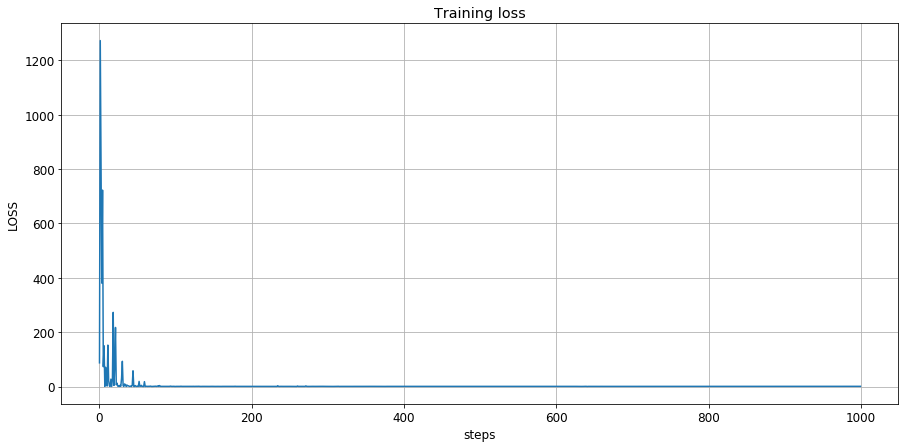

In [115]:
plt.figure(figsize=(15,7))
n = len(TOTAL_LOSS)
plt.plot(range(n),TOTAL_LOSS[:]   )


plt.xlabel('steps')
plt.ylabel('LOSS')
plt.grid()
plt.title( 'Training loss' )
plt.savefig(PLOT_DIRECTORY + 'Training_loss: model GCN: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png')  

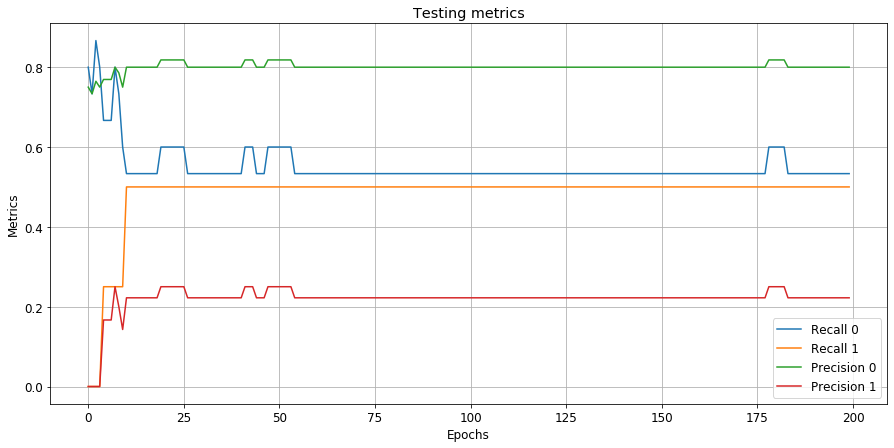

In [116]:
plt.figure(figsize=(15,7))
n = len(recall_class_0)
x_axis = range(n)
plt.plot(x_axis,recall_class_0, label = 'Recall 0'  )
plt.plot(x_axis,recall_class_1, label = 'Recall 1'  )
plt.plot(x_axis,precision_class_0, label = 'Precision 0'  )
plt.plot(x_axis,precision_class_1, label = 'Precision 1'  )
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Testing metrics')
plt.legend()
plt.grid()
plt.savefig(PLOT_DIRECTORY + 'Test_recall_precision: model GCN: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

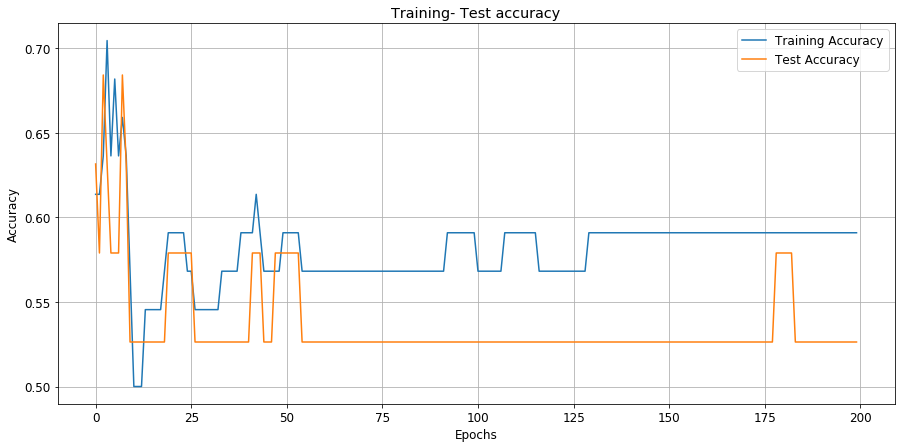

In [117]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch)
plt.plot(range(n),Train_accuracy[:],label= 'Training Accuracy'   )
plt.plot(range(n),Test_accuracy[:], label= 'Test Accuracy' )



plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title( 'Training- Test accuracy' )
plt.savefig(PLOT_DIRECTORY + 'Train -Test Accuracy: model GCN: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png')
#plt.savefig(PLOT_DIRECTORY + 'Train-Test Accuracy: model GCN Best.png')


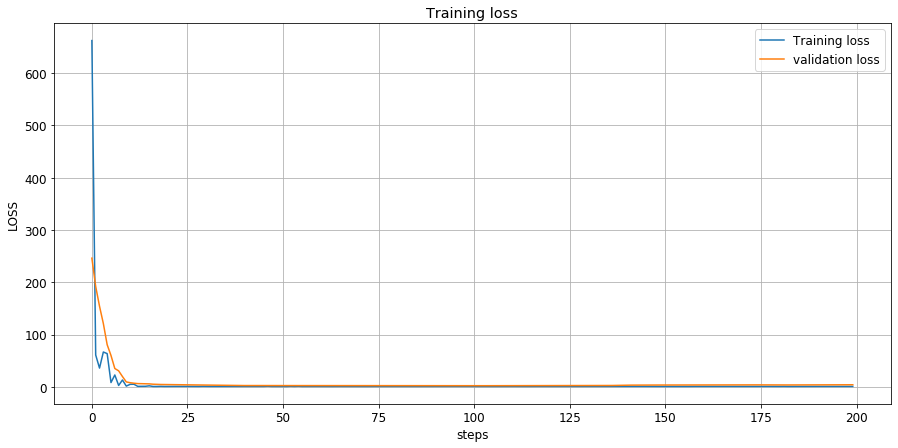

In [118]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch)
plt.plot(range(n),LOSS_epoch[:],label= 'Training loss'   )
plt.plot(range(n),TEST_epoch[:], label= 'validation loss' )



plt.xlabel('steps')
plt.ylabel('LOSS')
plt.grid()
plt.legend()
plt.title( 'Training loss' )
plt.savefig(PLOT_DIRECTORY + 'Training_vs_Validation_loss: model GCN: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

## Weights and Biases : Sweeps

In [119]:

sweep_config = {
  "name" : "GCN_sweep",
  "method" : "grid",
   "metric":{
  "name" : "loss"},
  
  "parameters" : {
    "epochs" : {
      "values" : [200]
    },
    "learning_rate" :{
      "min": 0.0001,
      "max": 0.1
    },
      "batch_size" : {
          "distribution" :'int_uniform',
          "min":1,
          "max":40
      },
      
      "class_1_weight": {
          
          "min":1,
          "max":20
      }
      
      
  }
}

#sweep_id = wandb.sweep(sweep_config,project='oncology-project')

In [120]:
#def train_1():
#    with wandb.init() as run:
#        config = wandb.config
#        BATCH_SIZE = config["batch_size"]
#        LR = config["learning_rate"]
#        DROPOUT = 0
#        CLASS_1_WEIGHT = config["class_1_weight"]
#        WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
        
#        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)    
        
        
#        model = GCN(IN_CHANNELS,HIDDEN_CHANNELS,N_CLASSES, DROPOUT).double()
        
#        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#        criterion = torch.nn.CrossEntropyLoss(WEIGHTS).double()
    
#        for epoch in range(1, 201):
#            loss = train()
#            avg_loss = np.mean(loss)
#            wandb.log({"loss": np.mean(loss)})
        

#count = 10 # number of runs to execute
#wandb.agent(sweep_id = 'x8o354ox', function=train_1,count=count)

## 10-fold Cross validation  

In [121]:
N_FOLDS = 5
Learning_rate = 0.01
IN_CHANNELS = 64
HIDDEN_CHANNELS = BATCH_SIZE
N_CLASSES = 2
DROPOUT = 0
CLASS_1_WEIGHT = 3
ALPHA = 5
GAMMA = 5
BATCH_SIZE = 10


index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)





WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)


TRAIN_ACC_BOXPLOT = []
TEST_ACC_BOXPLOT = []
RECALL_1_BOXPLOT = []
RECALL_0_BOXPLOT = []
PRECISION_1_BOXPLOT = []
PRECISION_0_BOXPLOT = []
CONVERGED_TRAINING_LOSS = []
CONVERGED_VALID_LOSS = []


for step in range(N_FOLDS):
    
    print('Fold : ',step)
 
    model = GCN(IN_CHANNELS,HIDDEN_CHANNELS,N_CLASSES, DROPOUT).double()
    criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)
    opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)
    opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)
    optimizer = opt_1
    
    train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
    train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

    train_indicies = train_indicies_class_1 + train_indicies_class_0
    test_indicies = test_indicies_class_1 + test_indicies_class_0 

    train_dataset = [patients_dataset[i] for i in train_indicies] 
    test_dataset = [patients_dataset[i] for i in test_indicies]

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) 
    
  
    
    LOSS_epoch = []
    TOTAL_LOSS = []
    TEST_epoch = []
    recall_class_0 =[]
    precision_class_0 =[]
    recall_class_1 =[]
    precision_class_1 =[]

    Train_accuracy = []
    Test_accuracy = []


    for epoch in range(1, 201):
        loss = train()
        test_loss = valid()
        #print(loss)
        TOTAL_LOSS = TOTAL_LOSS + loss
        LOSS_epoch.append(np.mean(loss))
        TEST_epoch.append(np.mean(test_loss))
        train_acc = test(train_loader)[0]
        #print('test')
        test_acc = test(test_loader)[0]
        recall_1 = test(test_loader)[2]
        precision_1 = test(test_loader)[1]
        precision_0 = test(test_loader)[3]
        recall_0 = test(test_loader)[4]
    
        recall_class_0.append(recall_0)
        recall_class_1.append(recall_1)
    
        precision_class_0.append(precision_0)
        precision_class_1.append(precision_1)
   
        Train_accuracy.append(train_acc)
        Test_accuracy.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
        
    TRAIN_ACC_BOXPLOT.append(train_acc)
    TEST_ACC_BOXPLOT.append(test_acc)
    RECALL_1_BOXPLOT.append(recall_1)
    RECALL_0_BOXPLOT.append(recall_0)
    PRECISION_1_BOXPLOT.append(precision_1)
    PRECISION_0_BOXPLOT.append(precision_0)
    CONVERGED_TRAINING_LOSS.append(np.mean(loss))
    CONVERGED_VALID_LOSS.append(np.mean(test_loss))  



Fold :  0


invalid value encountered in long_scalars


Epoch: 200, Train Acc: 0.8636, Test Acc: 0.5789, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7333,recall_0: 0.7333
Fold :  1
Epoch: 200, Train Acc: 0.7955, Test Acc: 0.7368, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7778,recall_0: 0.9333
Fold :  2
Epoch: 200, Train Acc: 0.9318, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
Fold :  3
Epoch: 200, Train Acc: 0.8409, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 0.7895,recall_0: 1.0000
Fold :  4
Epoch: 200, Train Acc: 0.8636, Test Acc: 0.7368, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7778,recall_0: 0.9333


In [122]:
losses = pd.DataFrame({},columns =['training_loss', 'validation_loss'])
losses['training_loss'] = CONVERGED_TRAINING_LOSS
losses['validation_loss'] = CONVERGED_VALID_LOSS

In [123]:
metrics = pd.DataFrame({},columns =['train accuracy', 'test accuracy', 'recall_1', 'precision_1', 'recall_0','precision_0'])
metrics['train accuracy'] = TRAIN_ACC_BOXPLOT
metrics['test accuracy'] = TEST_ACC_BOXPLOT
metrics['recall_1'] = RECALL_1_BOXPLOT
metrics['recall_0'] = RECALL_0_BOXPLOT
metrics['precision_1'] = PRECISION_1_BOXPLOT
metrics['precision_0'] = PRECISION_0_BOXPLOT





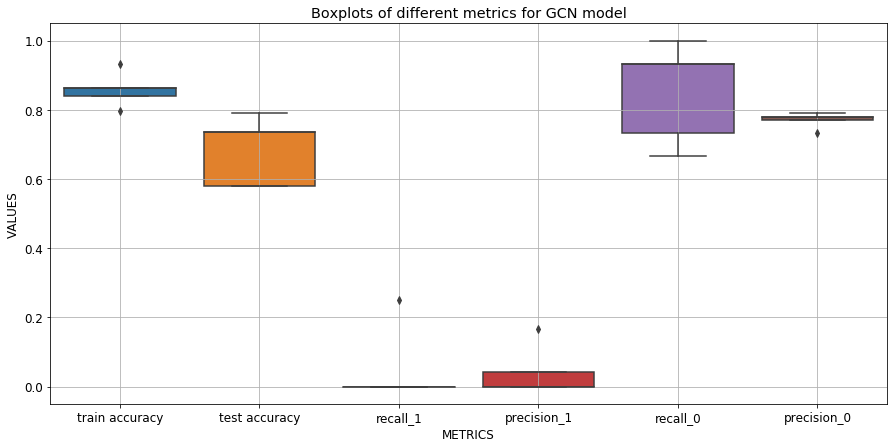

In [124]:
plt.figure(figsize=(15,7))
sns.boxplot(data=metrics)
plt.xlabel('METRICS')
plt.ylabel('VALUES')
plt.grid()
plt.title( 'Boxplots of different metrics for GCN model' )
plt.savefig(PLOT_DIRECTORY + 'BOXPLOTS GCN: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

# SAGEConv

# GAT 

The graph attentional operator from the "Graph Attention Networks" paper
$$
\mathbf{x}_{i}^{\prime}=\alpha_{i, i} \boldsymbol{\Theta} \mathbf{x}_{i}+\sum_{j \in \mathcal{N}(i)} \alpha_{i, j} \boldsymbol{\Theta} \mathbf{x}_{j}
$$
where the attention coefficients $\alpha_{i, j}$ are computed as
$$
\alpha_{i, j}=\frac{\exp \left(\operatorname{LeakyReLU}\left(\mathbf{a}^{\top}\left[\boldsymbol{\Theta} \mathbf{x}_{i} \| \boldsymbol{\Theta} \mathbf{x}_{j}\right]\right)\right)}{\sum_{k \in \mathcal{N}(i) \cup\{i\}} \exp \left(\operatorname{LeakyReLU}\left(\mathbf{a}^{\top}\left[\boldsymbol{\Theta} \mathbf{x}_{i} \| \boldsymbol{\Theta} \mathbf{x}_{k}\right]\right)\right)}
$$
PARAMETERS:\
$\quad$ - in_channels (int or tuple) - Size of each input sample. A tuple corresponds to the sizes of source and target dimensionalities.
- out_channels (int) - Size of each output sample.
- heads (int, optional) - Number of multi-head-attentions. (default: 1 )
- concat (bool, optional) - If set to Fatse, the multi-head attentions are
averaged instead of concatenated. (default: True )
- negative_slope (float, optional) - LeakyReLU angle of the negative slope. (default: $0.2$ )
- dropout (float, optional) - Dropout probability of the normalized attention coefficients which exposes each node to a stochastically sampled neighborhood during training. (default: 0 )
- add_self_loops (bool, optional) - If set to False, will not add self-loops
to the input graph. (default: True )
- bias (bool, optional) - If set to False, the layer will not learn an additive
bias. (default: True)
- $^{* *}$ kwargs (optional) - Additional arguments of
torch_geometric.nn. conv.MessagePassing.

In [125]:
class GAT(nn.Module):
    def __init__(self, hidden_channels, out_channels, first_heads, output_heads, dropout):
        super(GAT, self).__init__()
        self.gc1 = GATConv(64, hidden_channels,
                           heads=first_heads, dropout=dropout)
        
        self.gc2 = GATConv(hidden_channels*first_heads, hidden_channels,
                           heads=output_heads, dropout=dropout)
        
        self.dropout = dropout
        self.lin = Linear(hidden_channels, 2)


    def reset_parameters(self):
        self.gc1.reset_parameters()
        self.gc2.reset_parameters()

    def forward(self, data):
        x, edge_index, batch= data.x, data.edge_index, data.batch
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gc1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gc2(x, edge_index)
        x = F.relu(x)
        
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        
        return F.log_softmax(x, dim=1)

In [126]:
BATCH_SIZE = 10


index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)

train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

train_indicies = train_indicies_class_1 + train_indicies_class_0
test_indicies = test_indicies_class_1 + test_indicies_class_0 

train_dataset = [patients_dataset[i] for i in train_indicies] 
test_dataset = [patients_dataset[i] for i in test_indicies]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) 
#wandb.init(project='oncology-project')

Learning_rate = 0.01
IN_CHANNELS = 64
HIDDEN_CHANNELS = BATCH_SIZE
N_CLASSES = 2
DROPOUT = 0
CLASS_1_WEIGHT = 3




model = GAT( hidden_channels =BATCH_SIZE, out_channels =2,first_heads=8, output_heads=1, dropout=DROPOUT).double()

opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)

opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)

optimizer = opt_1


WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)
#criterion = FocalLoss(GAMMA,ALPHA)

LOSS_epoch = []
TOTAL_LOSS = []
TEST_epoch = []
recall_class_0 =[]
precision_class_0 =[]
recall_class_1 =[]
precision_class_1 =[]

Train_accuracy = []
Test_accuracy = []


for epoch in range(1, 201):
    loss = train()
    test_loss = valid()
    print(loss)
    TOTAL_LOSS = TOTAL_LOSS + loss
    LOSS_epoch.append(np.mean(loss))
    TEST_epoch.append(np.mean(test_loss))
    train_acc = test(train_loader)[0]
    print('test')
    test_acc = test(test_loader)[0]
    recall_1 = test(test_loader)[2]
    precision_1 = test(test_loader)[1]
    precision_0 = test(test_loader)[3]
    recall_0 = test(test_loader)[4]
    
    recall_class_0.append(recall_0)
    recall_class_1.append(recall_1)
    
    precision_class_0.append(precision_0)
    precision_class_1.append(precision_1)
   
    Train_accuracy.append(train_acc)
    Test_accuracy.append(test_acc)



    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
    #wandb.log({"loss": np.mean(loss),"Train accuracy": train_acc, "Test acuuracy":test_acc, 'precision_1':precision_1,'recall_1':recall_1,'precision_0': precision_0,'recall_0': recall_0})
    
    
    

[89.20441051994892, 193.79193653505013, 23.047354029135448, 200.53527613494649, 463.7860965373033]
test
Epoch: 001, Train Acc: 0.6591, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[41.40457759707391, 278.84375365054694, 27.426654247792076, 86.33793187320983, 335.7556728238175]
test
Epoch: 002, Train Acc: 0.7500, Test Acc: 0.4737, precision_1: 0.2000, recall_1: 0.5000,precision_0: 0.7778,recall_0: 0.4667
[41.54614267356775, 11.605427581985056, 37.82420108617322, 9.323679132009824, 57.29719830442788]
test
Epoch: 003, Train Acc: 0.8636, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[17.77359927378011, 6.661280095995142, 3.1110563338317747, 44.345767879258354, 6.224357021495263]
test
Epoch: 004, Train Acc: 0.8182, Test Acc: 0.5263, precision_1: 0.2727, recall_1: 0.7500,precision_0: 0.8750,recall_0: 0.4667
[3.7617467431731644, 1.0508865285615003, 0.008196028221252498, 12.462443893279431, 0.0009747

Epoch: 036, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.032283519695975205, 0.021231135572002846, 0.04681670989963918, 0.029677495514550095, 0.05724941252382864]
test
Epoch: 037, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.0006105192213489802, 0.07460571698234655, 0.02895938051804524, 0.058718507519285264, 0.0]
test
Epoch: 038, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.06463043077455706, 0.02728304237411816, 0.02344710127090158, 0.02667245643339474, 0.0648135161986408]
test
Epoch: 039, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.0656938631870762, 0.026294307399987577, 0.022893090787432815, 0.005398664796929058, 0.15930846949315072]
test
Epoch: 040, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000,

Epoch: 071, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.02596783106128484, 0.003316449773293115, 0.012757326108281303, 0.018100715897297278, 0.06856200832594446]
test
Epoch: 072, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.0018313901472107423, 0.026486202203308624, 0.018188322717702127, 0.013869643793736784, 0.048392702349725446]
test
Epoch: 073, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.022360065269096067, 0.01394722823669959, 0.027450440765198657, 0.0148595833944268, 3.4416913763378666e-14]
test
Epoch: 074, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.028786928033908452, 0.034802606597115815, 0.011028956448576524, 0.0005533811434646466, 0.0024288392916725003]
test
Epoch: 075, Train Acc: 1.0000, Test Acc:

[0.0245095100230814, 0.01219435844174602, 0.017528569233568186, 0.0011611530547157398, 0.002705569295791577]
test
Epoch: 106, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.010454107497224578, 0.002136092216040541, 0.007617560336063381, 0.03198755583717811, 3.2269890151087673e-09]
test
Epoch: 107, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.0073276951373186195, 0.018986274119781436, 0.02278509154493861, 0.0019294408442386503, 0.0018108461348315843]
test
Epoch: 108, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.010409652105708815, 0.019173674216106627, 0.0027457056975049715, 0.015422851853320712, 0.0]
test
Epoch: 109, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.007053648366373389, 0.01706073952397474, 0.003504910

Epoch: 140, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.01346462039804804, 0.002062718177948865, 0.0075577643429978235, 0.008544703121011533, 6.07667007197245e-05]
test
Epoch: 141, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.008186177415088135, 0.007566994717745668, 0.008211432609266893, 0.0068290675093761605, 4.570686176614613e-09]
test
Epoch: 142, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.007864242802521728, 0.001547016189929205, 0.006967330912924312, 0.01787226359311783, 0.0007657688617975912]
test
Epoch: 143, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.007049928476881575, 0.005852128510753191, 0.01768050595504181, 0.0010994112747385253, 0.005852121747527436]
test
Epoch: 144, Train Acc: 1.0000, Test Ac

[0.0006591213671378245, 0.005194245907551769, 0.005327273733303119, 0.005993222879667748, 0.0]
test
Epoch: 175, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.001271558550552458, 0.001400516339192538, 0.0004786061146612253, 0.010527858134140613, 0.008847356535945239]
test
Epoch: 176, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.0008966324511608156, 0.0011693510954821462, 0.01055913348592751, 0.005515130542949125, 0.00030515801690263693]
test
Epoch: 177, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.004416633862007803, 0.001478951542097976, 0.005615125414505119, 0.006117537518075734, 0.0]
test
Epoch: 178, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.0021917614852876607, 0.0058131692211864415, 0.01033837874889959, 2

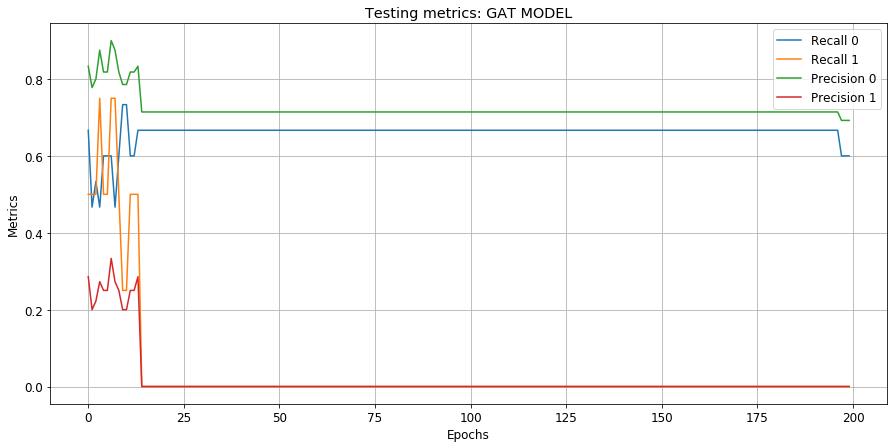

In [127]:
plt.figure(figsize=(15,7))
n = len(recall_class_0)
x_axis = range(n)
plt.plot(x_axis,recall_class_0, label = 'Recall 0'  )
plt.plot(x_axis,recall_class_1, label = 'Recall 1'  )
plt.plot(x_axis,precision_class_0, label = 'Precision 0'  )
plt.plot(x_axis,precision_class_1, label = 'Precision 1'  )
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Testing metrics: GAT MODEL')
plt.legend()
plt.grid()
plt.savefig(PLOT_DIRECTORY + 'Test_recall_precision: model GAT: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

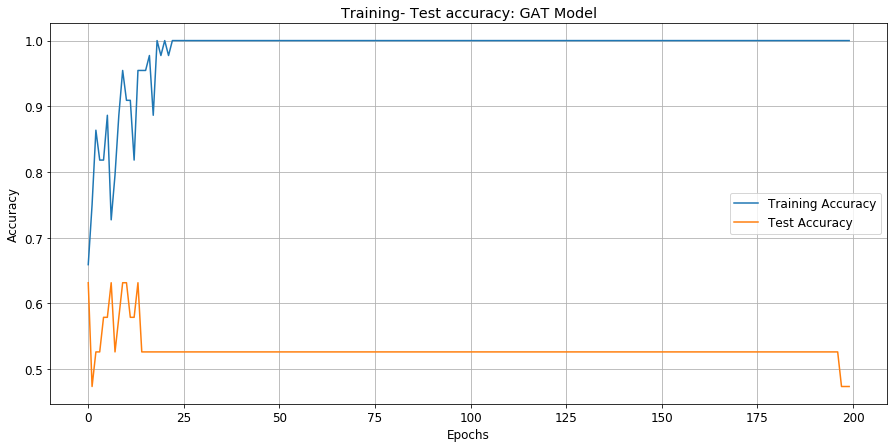

In [128]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch)
plt.plot(range(n),Train_accuracy[:],label= 'Training Accuracy'   )
plt.plot(range(n),Test_accuracy[:], label= 'Test Accuracy' )
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title( 'Training- Test accuracy: GAT Model' )
plt.savefig(PLOT_DIRECTORY + 'Train -Test Accuracy: model GAT: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png')
#plt.savefig(PLOT_DIRECTORY + 'Train-Test Accuracy: model GCN Best.png')

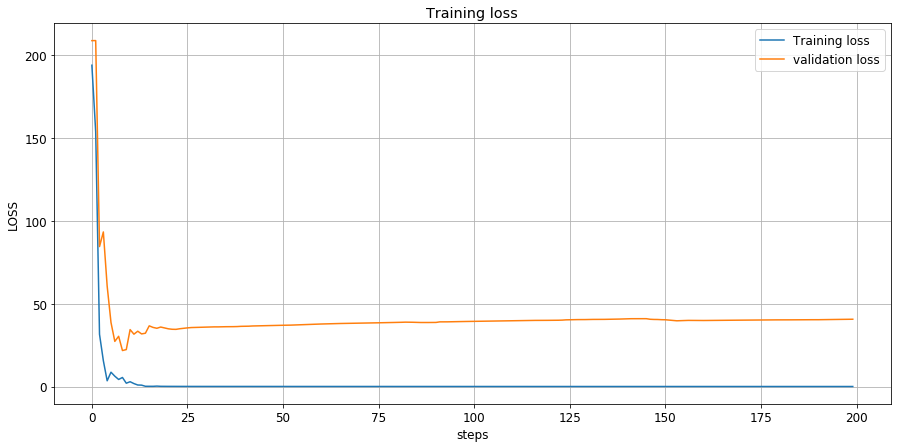

In [129]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch)
plt.plot(range(n),LOSS_epoch[:],label= 'Training loss'   )
plt.plot(range(n),TEST_epoch[:], label= 'validation loss' )



plt.xlabel('steps')
plt.ylabel('LOSS')
plt.grid()
plt.legend()
plt.title( 'Training loss' )
plt.savefig(PLOT_DIRECTORY + 'Training_vs_Validation_loss: model GAT: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

## GAT CROSS VALIDATION

In [130]:
N_FOLDS = 7
Learning_rate = 0.01
IN_CHANNELS = 64
HIDDEN_CHANNELS = BATCH_SIZE
N_CLASSES = 2
DROPOUT = 0
CLASS_1_WEIGHT = 2
BATCH_SIZE = 10


index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)




WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)


TRAIN_ACC_BOXPLOT = []
TEST_ACC_BOXPLOT = []
RECALL_1_BOXPLOT = []
RECALL_0_BOXPLOT = []
PRECISION_1_BOXPLOT = []
PRECISION_0_BOXPLOT = []
CONVERGED_TRAINING_LOSS = []
CONVERGED_VALID_LOSS = []


for step in range(N_FOLDS):
    
    print('Fold : ',step)
 
    model = GAT( hidden_channels =BATCH_SIZE, out_channels =2,first_heads=8, output_heads=1, dropout=DROPOUT).double()
    criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)
    opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)
    opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)
    optimizer = opt_1
    
    train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
    train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

    train_indicies = train_indicies_class_1 + train_indicies_class_0
    test_indicies = test_indicies_class_1 + test_indicies_class_0 

    train_dataset = [patients_dataset[i] for i in train_indicies] 
    test_dataset = [patients_dataset[i] for i in test_indicies]

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) 
    
  
    
    LOSS_epoch = []
    TOTAL_LOSS = []
    TEST_epoch = []
    recall_class_0 =[]
    precision_class_0 =[]
    recall_class_1 =[]
    precision_class_1 =[]

    Train_accuracy = []
    Test_accuracy = []


    for epoch in range(1, 201):
        loss = train()
        test_loss = valid()
        #print(loss)
        TOTAL_LOSS = TOTAL_LOSS + loss
        LOSS_epoch.append(np.mean(loss))
        TEST_epoch.append(np.mean(test_loss))
        train_acc = test(train_loader)[0]
        #print('test')
        test_acc = test(test_loader)[0]
        recall_1 = test(test_loader)[2]
        precision_1 = test(test_loader)[1]
        precision_0 = test(test_loader)[3]
        recall_0 = test(test_loader)[4]
    
        recall_class_0.append(recall_0)
        recall_class_1.append(recall_1)
    
        precision_class_0.append(precision_0)
        precision_class_1.append(precision_1)
   
        Train_accuracy.append(train_acc)
        Test_accuracy.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
        
    TRAIN_ACC_BOXPLOT.append(train_acc)
    TEST_ACC_BOXPLOT.append(test_acc)
    RECALL_1_BOXPLOT.append(recall_1)
    RECALL_0_BOXPLOT.append(recall_0)
    PRECISION_1_BOXPLOT.append(precision_1)
    PRECISION_0_BOXPLOT.append(precision_0)
    CONVERGED_TRAINING_LOSS.append(np.mean(loss))
    CONVERGED_VALID_LOSS.append(np.mean(test_loss))  


Fold :  0


invalid value encountered in long_scalars


Epoch: 200, Train Acc: 0.9773, Test Acc: 0.6842, precision_1: 0.3333, recall_1: 0.5000,precision_0: 0.8462,recall_0: 0.7333
Fold :  1
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
Fold :  2
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.7895, precision_1: 0.5000, recall_1: 0.5000,precision_0: 0.8667,recall_0: 0.8667
Fold :  3
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3333, recall_1: 0.5000,precision_0: 0.8462,recall_0: 0.7333
Fold :  4
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.7895, precision_1: 0.5000, recall_1: 0.2500,precision_0: 0.8235,recall_0: 0.9333
Fold :  5
Epoch: 200, Train Acc: 0.9318, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
Fold :  6
Epoch: 200, Train Acc: 0.8409, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333


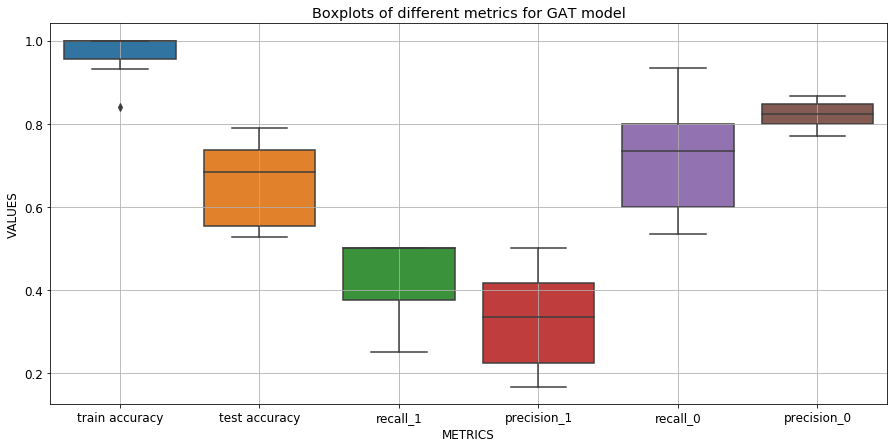

In [131]:
losses_GAT = pd.DataFrame({},columns =['training_loss', 'validation_loss'])
losses_GAT['training_loss'] = CONVERGED_TRAINING_LOSS
losses_GAT['validation_loss'] = CONVERGED_VALID_LOSS


metrics_GAT = pd.DataFrame({},columns =['train accuracy', 'test accuracy', 'recall_1', 'precision_1', 'recall_0','precision_0'])
metrics_GAT['train accuracy'] = TRAIN_ACC_BOXPLOT
metrics_GAT['test accuracy'] = TEST_ACC_BOXPLOT
metrics_GAT['recall_1'] = RECALL_1_BOXPLOT
metrics_GAT['recall_0'] = RECALL_0_BOXPLOT
metrics_GAT['precision_1'] = PRECISION_1_BOXPLOT
metrics_GAT['precision_0'] = PRECISION_0_BOXPLOT

plt.figure(figsize=(15,7))
sns.boxplot(data=metrics_GAT)
plt.xlabel('METRICS')
plt.ylabel('VALUES')
plt.grid()
plt.title( 'Boxplots of different metrics for GAT model' )
plt.savefig(PLOT_DIRECTORY + 'BOXPLOTS METRICS GAT: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

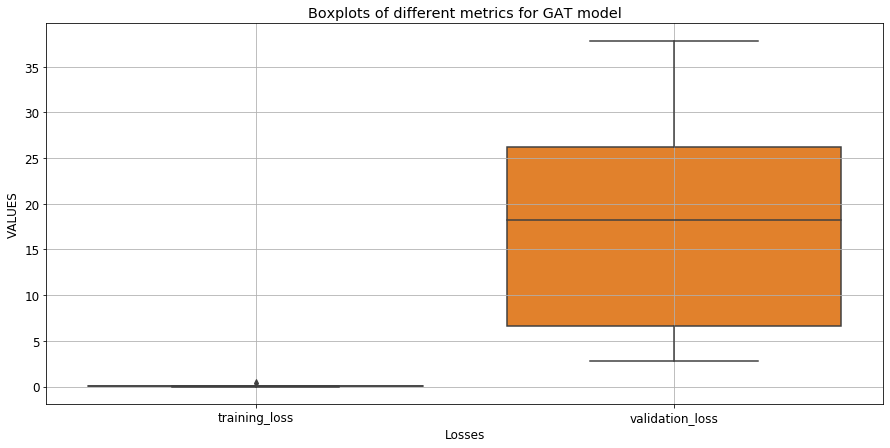

In [132]:
plt.figure(figsize=(15,7))
sns.boxplot(data=losses_GAT)
plt.xlabel('Losses')
plt.ylabel('VALUES')
plt.grid()
plt.title( 'Boxplots of different metrics for GAT model' )
plt.savefig(PLOT_DIRECTORY + 'BOXPLOTS LOSSES GAT: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

# SGC : Simple graph convolution

The simple graph convolutional operator from the "Simplifying Graph Convolutional Networks"
paper
$$
\mathbf{X}^{\prime}=\left(\hat{\mathbf{D}}^{-1 / 2} \hat{\mathbf{A}} \hat{\mathbf{D}}^{-1 / 2}\right)^{K} \mathbf{X} \boldsymbol{\Theta}
$$
where $\hat{\mathbf{A}}=\mathbf{A}+\mathbf{I}$ denotes the adjacency matrix with inserted self-loops and $\hat{D}_{i i}=\sum_{j=0} \hat{A}_{i j}$ its diagonal degree matrix. The adjacency matrix can include other values than 1 representing edge weights via the optional edge_weight tensor.
PARAMETERS:
- in_channels (int) - Size of each input sample.
- out_channels (int) - Size of each output sample.
- $\mathrm{K}$ (int, optional) - Number of hops $K$. (default: 1 )
- cached (bool, optional) - If set to True, the layer will cache the computation of $\left(\hat{\mathbf{D}}^{-1 / 2} \hat{\mathbf{A}} \hat{\mathbf{D}}^{-1 / 2}\right)^{K} \mathbf{X}$ on first execution, and will use the cached version for further executions. This parameter should only be set to True in transductive learning scenarios. (default: False)
- add_self_loops (bool, optional) - If set to Fatse, will not add self-loops to the input graph. (default: True )
- bias (bool, optional) - If set to False, the layer will not learn an additive bias. (default: True)
- $^{* *}$ kwargs (optional) - Additional arguments of torch_geometric.nn. conv.MessagePassing.

In [133]:
from torch_geometric.nn import SGConv


class SGC(nn.Module):
    def __init__(self,hidden_channels, K):
        super(SGC, self).__init__()
        self.gc1 = SGConv(64, hidden_channels, K=K,add_self_loops=True)
        self.gc2 = SGConv(hidden_channels, hidden_channels, K=K,add_self_loops=True)

        self.lin = Linear(hidden_channels, 2)

    def reset_parameters(self):
        self.gc1.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.gc1(x, edge_index)
        x= F.relu(x)
        x = self.gc2(x, edge_index)
        x= F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=1)
    
    

In [134]:
BATCH_SIZE = 10


index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)

train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

train_indicies = train_indicies_class_1 + train_indicies_class_0
test_indicies = test_indicies_class_1 + test_indicies_class_0 

train_dataset = [patients_dataset[i] for i in train_indicies] 
test_dataset = [patients_dataset[i] for i in test_indicies]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) 
#wandb.init(project='oncology-project')

Learning_rate = 0.01
IN_CHANNELS = 64
HIDDEN_CHANNELS = BATCH_SIZE
N_CLASSES = 2
DROPOUT = 0
CLASS_1_WEIGHT = 3
K = 2




model = SGC(hidden_channels=BATCH_SIZE,K=K).double()

opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)

opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)

optimizer = opt_1


WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)
#criterion = FocalLoss(GAMMA,ALPHA)

LOSS_epoch = []
TOTAL_LOSS = []
TEST_epoch = []
recall_class_0 =[]
precision_class_0 =[]
recall_class_1 =[]
precision_class_1 =[]

Train_accuracy = []
Test_accuracy = []


for epoch in range(1, 201):
    loss = train()
    test_loss = valid()
    print(loss)
    TOTAL_LOSS = TOTAL_LOSS + loss
    LOSS_epoch.append(np.mean(loss))
    TEST_epoch.append(np.mean(test_loss))
    train_acc = test(train_loader)[0]
    print('test')
    test_acc = test(test_loader)[0]
    recall_1 = test(test_loader)[2]
    precision_1 = test(test_loader)[1]
    precision_0 = test(test_loader)[3]
    recall_0 = test(test_loader)[4]
    
    recall_class_0.append(recall_0)
    recall_class_1.append(recall_1)
    
    precision_class_0.append(precision_0)
    precision_class_1.append(precision_1)
   
    Train_accuracy.append(train_acc)
    Test_accuracy.append(test_acc)



    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
    #wandb.log({"loss": np.mean(loss),"Train accuracy": train_acc, "Test acuuracy":test_acc, 'precision_1':precision_1,'recall_1':recall_1,'precision_0': precision_0,'recall_0': recall_0})
    
    

[68.52171609001768, 84.99007976902044, 70.03477041192154, 30.626298151458535, 48.14939701570478]
test
Epoch: 001, Train Acc: 0.6818, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[28.983068766691638, 1.5587802861888171, 3.3068740064355016, 14.118537446059538, 15.270550267153046]
test
Epoch: 002, Train Acc: 0.5455, Test Acc: 0.3684, precision_1: 0.1000, recall_1: 0.2500,precision_0: 0.6667,recall_0: 0.4000
[18.140357704865085, 20.397531165096776, 0.29144165891846463, 0.551594639074224, 25.37244518817896]
test
Epoch: 003, Train Acc: 0.8636, Test Acc: 0.7368, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7778,recall_0: 0.9333
[4.888652464850528e-07, 7.211734321633128, 0.738763889838107, 7.372713746520608, 17.799030985065436]
test
Epoch: 004, Train Acc: 0.8864, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[3.3889150194334015, 5.079952095309602, 1.41315856763577, 19.02404469570237, 4.707752

Epoch: 036, Train Acc: 0.9545, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000
[0.011239581761124542, 0.17998962501850133, 0.005530391248854019, 7.15652351454931e-05, 0.3453968959355624]
test
Epoch: 037, Train Acc: 0.9773, Test Acc: 0.5263, precision_1: 0.1429, recall_1: 0.2500,precision_0: 0.7500,recall_0: 0.6000
[0.056670100202430004, 0.1538149844942014, 0.10042512754242694, 0.016201610047202674, 6.324570496946776e-14]
test
Epoch: 038, Train Acc: 0.9773, Test Acc: 0.5263, precision_1: 0.1429, recall_1: 0.2500,precision_0: 0.7500,recall_0: 0.6000
[0.003818039693442983, 0.08665130422864298, 0.0014716988352675045, 0.1637759691334824, 0.06652883400314336]
test
Epoch: 039, Train Acc: 0.9773, Test Acc: 0.5263, precision_1: 0.1429, recall_1: 0.2500,precision_0: 0.7500,recall_0: 0.6000
[0.10260532890667358, 0.0877166612654745, 0.134280558653488, 0.002916581450939317, 0.0017916144215105395]
test
Epoch: 040, Train Acc: 0.9773, Test Acc: 0.4737, prec

Epoch: 071, Train Acc: 0.9773, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000
[0.0034823991639920185, 0.006120754257173357, 0.18952015078744483, 0.0018413485899006397, 0.0005894192371473152]
test
Epoch: 072, Train Acc: 0.9773, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000
[0.20889524812523433, 0.06254778478354568, 0.0023648587818455398, 0.0002614151380552041, 1.8709048244573026e-05]
test
Epoch: 073, Train Acc: 0.9773, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000
[0.06127905581113203, 0.06642405938151402, 0.14544504664852959, 0.0020425721264877893, 0.00044006415476652153]
test
Epoch: 074, Train Acc: 0.9773, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000
[0.0005528271665722575, 2.3543269122708817e-05, 0.06383595460928669, 0.06736122298803371, 0.23107719715516498]
test
Epoch: 075, Train Acc: 0.9773, Test 

Epoch: 106, Train Acc: 0.9773, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000
[0.16990606535472064, 0.03975558401364654, 0.003774358925988515, 0.00111989047634401, 5.883807760604492e-09]
test
Epoch: 107, Train Acc: 0.9773, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000
[0.001103976148768655, 0.11401974032664682, 0.00029142742282045993, 0.04645296293900215, 0.13173021623674155]
test
Epoch: 108, Train Acc: 0.9773, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000
[0.002113864813427487, 0.0024632614159282927, 0.14335322696923908, 0.04901632854247522, 5.6768262747043424e-05]
test
Epoch: 109, Train Acc: 0.9773, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000
[0.0001406926351335584, 0.04905635359769418, 0.11512362836499379, 0.04380051516139587, 0.005459295054118071]
test
Epoch: 110, Train Acc: 0.9773, Test Acc: 0.4

Epoch: 141, Train Acc: 0.9773, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000
[0.00035733624577912577, 0.12008232736092446, 0.05076413033581689, 0.040258025461308015, 1.3877787807814417e-15]
test
Epoch: 142, Train Acc: 0.9773, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000
[0.00019511520280664346, 0.12902824705422128, 0.00024965378046707954, 0.0507056935392926, 1.5045372355310755e-12]
test
Epoch: 143, Train Acc: 0.9773, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000
[0.0016027770242518912, 0.00014260688506274725, 0.05072245712224653, 0.12807121341279518, 5.551115123125782e-17]
test
Epoch: 144, Train Acc: 0.9773, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000
[0.0004840142752204427, 0.03510714737173967, 0.03862308265233635, 0.1702913383034602, 1.890151883292283e-09]
test
Epoch: 145, Train Acc: 0.9773, Test

Epoch: 176, Train Acc: 0.9773, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000
[0.0008833280722128969, 0.14591491495846792, 0.00016906056544153256, 0.00038062733253905405, 0.07818150365405291]
test
Epoch: 177, Train Acc: 0.9773, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000
[2.2721241523915494e-10, 0.03863144706045911, 0.11122599816533192, 0.03626953987756646, 0.0]
test
Epoch: 178, Train Acc: 0.9773, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000
[0.00020205386373622016, 0.0006605675654462672, 0.0007721690163701934, 0.035334361354907695, 0.3975826270682743]
test
Epoch: 179, Train Acc: 0.9773, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000
[0.19599046927573485, 1.0782034585472215e-05, 0.03821376486836619, 0.0005506865513761209, 2.3641908375066273e-09]
test
Epoch: 180, Train Acc: 0.9773, Test Acc: 0.4737, p

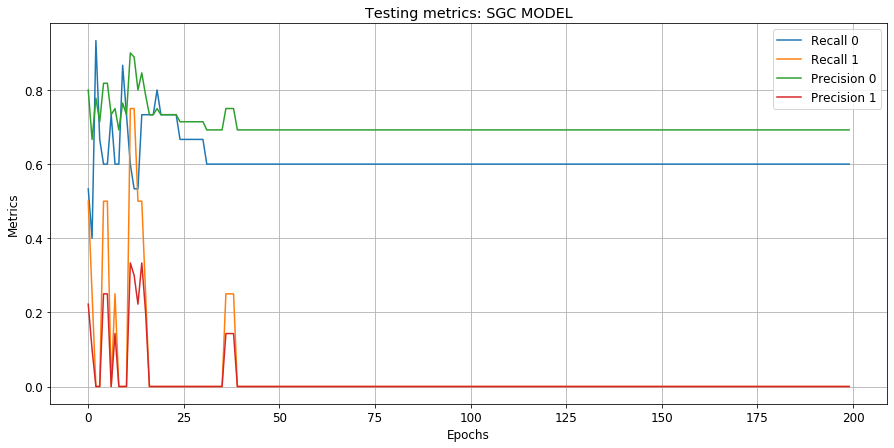

In [135]:
plt.figure(figsize=(15,7))
n = len(recall_class_0)
x_axis = range(n)
plt.plot(x_axis,recall_class_0, label = 'Recall 0'  )
plt.plot(x_axis,recall_class_1, label = 'Recall 1'  )
plt.plot(x_axis,precision_class_0, label = 'Precision 0'  )
plt.plot(x_axis,precision_class_1, label = 'Precision 1'  )
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Testing metrics: SGC MODEL')
plt.legend()
plt.grid()
plt.savefig(PLOT_DIRECTORY + 'Test_recall_precision: model SGC: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

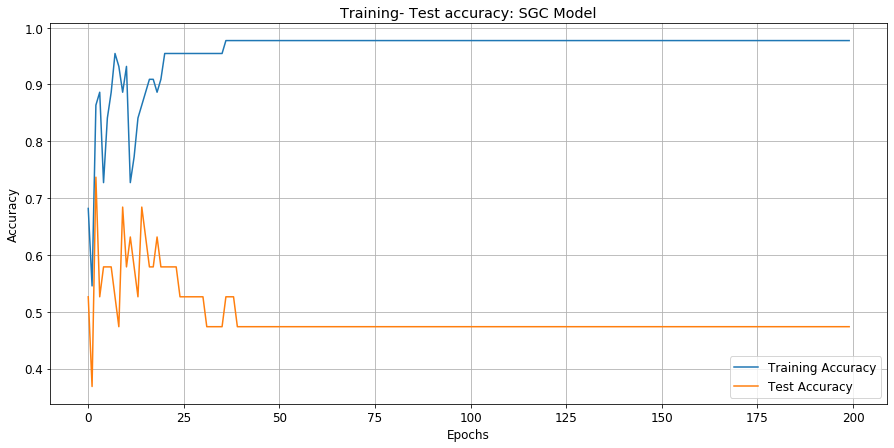

In [136]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch)
plt.plot(range(n),Train_accuracy[:],label= 'Training Accuracy'   )
plt.plot(range(n),Test_accuracy[:], label= 'Test Accuracy' )
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title( 'Training- Test accuracy: SGC Model' )
plt.savefig(PLOT_DIRECTORY + 'Train -Test Accuracy: model SGC: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png')
#plt.savefig(PLOT_DIRECTORY + 'Train-Test Accuracy: model GCN Best.png')

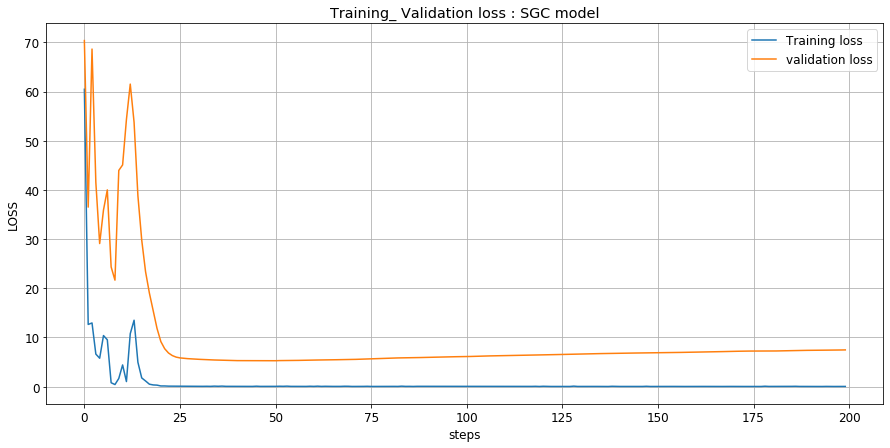

In [137]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch)
plt.plot(range(n),LOSS_epoch[:],label= 'Training loss'   )
plt.plot(range(n),TEST_epoch[:], label= 'validation loss' )



plt.xlabel('steps')
plt.ylabel('LOSS')
plt.grid()
plt.legend()
plt.title( 'Training_ Validation loss : SGC model' )
plt.savefig(PLOT_DIRECTORY + 'Training_vs_Validation_loss: model SGC: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

In [138]:
N_FOLDS = 9
Learning_rate = 0.01
IN_CHANNELS = 64
HIDDEN_CHANNELS = BATCH_SIZE
N_CLASSES = 2
DROPOUT = 0
CLASS_1_WEIGHT = 2
BATCH_SIZE = 10


index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)




WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)


TRAIN_ACC_BOXPLOT = []
TEST_ACC_BOXPLOT = []
RECALL_1_BOXPLOT = []
RECALL_0_BOXPLOT = []
PRECISION_1_BOXPLOT = []
PRECISION_0_BOXPLOT = []
CONVERGED_TRAINING_LOSS = []
CONVERGED_VALID_LOSS = []


for step in range(N_FOLDS):
    
    print('Fold : ',step)
 
    model = SGC(hidden_channels=BATCH_SIZE,K=K).double()
    criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)
    opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)
    opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)
    optimizer = opt_1
    
    train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
    train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

    train_indicies = train_indicies_class_1 + train_indicies_class_0
    test_indicies = test_indicies_class_1 + test_indicies_class_0 

    train_dataset = [patients_dataset[i] for i in train_indicies] 
    test_dataset = [patients_dataset[i] for i in test_indicies]

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True) 
    
  
    
    LOSS_epoch = []
    TOTAL_LOSS = []
    TEST_epoch = []
    recall_class_0 =[]
    precision_class_0 =[]
    recall_class_1 =[]
    precision_class_1 =[]

    Train_accuracy = []
    Test_accuracy = []


    for epoch in range(1, 201):
        loss = train()
        test_loss = valid()
        #print(loss)
        TOTAL_LOSS = TOTAL_LOSS + loss
        LOSS_epoch.append(np.mean(loss))
        TEST_epoch.append(np.mean(test_loss))
        train_acc = test(train_loader)[0]
        #print('test')
        test_acc = test(test_loader)[0]
        recall_1 = test(test_loader)[2]
        precision_1 = test(test_loader)[1]
        precision_0 = test(test_loader)[3]
        recall_0 = test(test_loader)[4]
    
        recall_class_0.append(recall_0)
        recall_class_1.append(recall_1)
    
        precision_class_0.append(precision_0)
        precision_class_1.append(precision_1)
   
        Train_accuracy.append(train_acc)
        Test_accuracy.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
        
    TRAIN_ACC_BOXPLOT.append(train_acc)
    TEST_ACC_BOXPLOT.append(test_acc)
    RECALL_1_BOXPLOT.append(recall_1)
    RECALL_0_BOXPLOT.append(recall_0)
    PRECISION_1_BOXPLOT.append(precision_1)
    PRECISION_0_BOXPLOT.append(precision_0)
    CONVERGED_TRAINING_LOSS.append(np.mean(loss))
    CONVERGED_VALID_LOSS.append(np.mean(test_loss)) 

Fold :  0
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.3333, recall_1: 0.2500,precision_0: 0.8125,recall_0: 0.8667
Fold :  1


invalid value encountered in long_scalars


Epoch: 200, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
Fold :  2
Epoch: 200, Train Acc: 0.9091, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
Fold :  3
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
Fold :  4
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.3333, recall_1: 0.7500,precision_0: 0.9000,recall_0: 0.6000
Fold :  5
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
Fold :  6
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
Fold :  7
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7778,recall_0: 0.9333
Fold :  8
Epoch: 200, Train Acc: 0.6818, Test Acc: 0.6316, precision_1: 

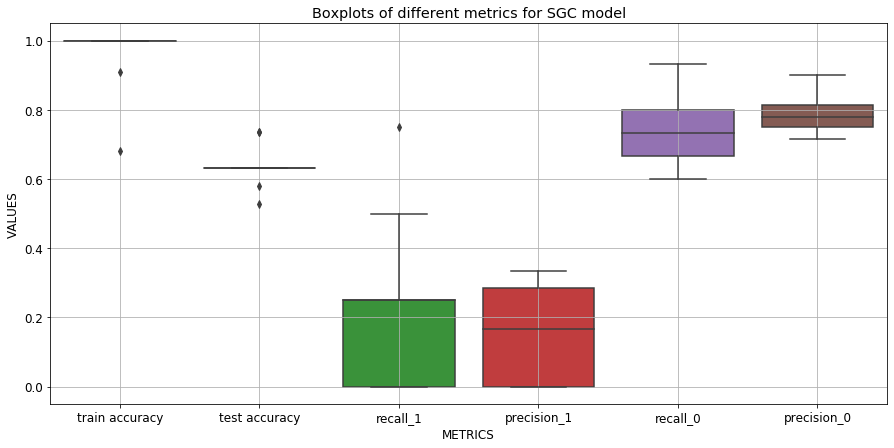

In [139]:
losses_SGC = pd.DataFrame({},columns =['training_loss', 'validation_loss'])
losses_SGC['training_loss'] = CONVERGED_TRAINING_LOSS
losses_SGC['validation_loss'] = CONVERGED_VALID_LOSS


metrics_SGC = pd.DataFrame({},columns =['train accuracy', 'test accuracy', 'recall_1', 'precision_1', 'recall_0','precision_0'])
metrics_SGC['train accuracy'] = TRAIN_ACC_BOXPLOT
metrics_SGC['test accuracy'] = TEST_ACC_BOXPLOT
metrics_SGC['recall_1'] = RECALL_1_BOXPLOT
metrics_SGC['recall_0'] = RECALL_0_BOXPLOT
metrics_SGC['precision_1'] = PRECISION_1_BOXPLOT
metrics_SGC['precision_0'] = PRECISION_0_BOXPLOT

plt.figure(figsize=(15,7))
sns.boxplot(data=metrics_SGC)
plt.xlabel('METRICS')
plt.ylabel('VALUES')
plt.grid()
plt.title( 'Boxplots of different metrics for SGC model' )
plt.savefig(PLOT_DIRECTORY + 'BOXPLOTS METRICS SGC: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

## SAGEConv

$$
\mathbf{x}_{i}^{\prime}=\mathbf{W}_{1} \mathbf{x}_{i}+\mathbf{W}_{2} \cdot \operatorname{mean}_{j \in \mathcal{N}(i)} \mathbf{x}_{j}
$$
PARAMETERS:
- in_channels (int or tuple) - Size of each input sample. A tuple corresponds to the sizes of source and target dimensionalities.
- out_channels (int) - Size of each output sample.
- normalize (bool, optional) - If set to True, output features will be $\ell_{2}$ normalized, i.e., $\frac{\mathbf{x}_{i}^{\prime}}{\left\|\mathbf{x}_{i}^{\prime}\right\|_{2}}$. (default: False)
- root_weight (bool, optional) - If set to False, the layer will not add transformed root node features to the output. (default: True )
- bias (bool, optional) - If set to False, the layer will not learn an additive bias. (default: True)
$=^{* *} \mathrm{kwargs}$ (optional) - Additional arguments of torch_geometric.nn. conv.MessagePassing.

In [140]:
from torch_geometric.nn import SAGEConv


class SAGE(nn.Module):
    def __init__(self,hidden_channels,normalize = True):
        super(SAGE, self).__init__()
        self.gc1 = SAGEConv(64, hidden_channels,normalize=normalize)
        self.gc2 = SAGEConv(hidden_channels, hidden_channels,normalize=normalize)
        self.lin = Linear(hidden_channels, 2)

    def reset_parameters(self):
        self.gc1.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.gc1(x, edge_index)
        x= F.relu(x)
        x = self.gc2(x, edge_index)
        x= F.relu(x)
            
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        
        return F.log_softmax(x, dim=1)
    
    

In [141]:
BATCH_SIZE = 10


index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)

train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

train_indicies = train_indicies_class_1 + train_indicies_class_0
test_indicies = test_indicies_class_1 + test_indicies_class_0 

train_dataset = [patients_dataset[i] for i in train_indicies] 
test_dataset = [patients_dataset[i] for i in test_indicies]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) 
#wandb.init(project='oncology-project')

Learning_rate = 0.01
IN_CHANNELS = 64
HIDDEN_CHANNELS = BATCH_SIZE
N_CLASSES = 2
DROPOUT = 0
CLASS_1_WEIGHT = 1
K = 2




model = SAGE(hidden_channels=BATCH_SIZE).double()

opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)

opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)

optimizer = opt_1


WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)
#criterion = FocalLoss(GAMMA,ALPHA)

LOSS_epoch = []
TOTAL_LOSS = []
TEST_epoch = []
recall_class_0 =[]
precision_class_0 =[]
recall_class_1 =[]
precision_class_1 =[]

Train_accuracy = []
Test_accuracy = []


for epoch in range(1, 201):
    loss = train()
    test_loss = valid()
    print(loss)
    TOTAL_LOSS = TOTAL_LOSS + loss
    LOSS_epoch.append(np.mean(loss))
    TEST_epoch.append(np.mean(test_loss))
    train_acc = test(train_loader)[0]
    print('test')
    test_acc = test(test_loader)[0]
    recall_1 = test(test_loader)[2]
    precision_1 = test(test_loader)[1]
    precision_0 = test(test_loader)[3]
    recall_0 = test(test_loader)[4]
    
    recall_class_0.append(recall_0)
    recall_class_1.append(recall_1)
    
    precision_class_0.append(precision_0)
    precision_class_1.append(precision_1)
   
    Train_accuracy.append(train_acc)
    Test_accuracy.append(test_acc)



    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
    #wandb.log({"loss": np.mean(loss),"Train accuracy": train_acc, "Test acuuracy":test_acc, 'precision_1':precision_1,'recall_1':recall_1,'precision_0': precision_0,'recall_0': recall_0})
    
    

[0.7898282449271841, 0.7038525689732119, 0.6972354924543827, 0.6701411295147304, 0.6267475728761983]
test
Epoch: 001, Train Acc: 0.7727, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 0.7895,recall_0: 1.0000
[0.6557621898568456, 0.6237164018137029, 0.6470757665363982, 0.5931655860464551, 0.5166156443564778]
test


invalid value encountered in long_scalars


Epoch: 002, Train Acc: 0.7727, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 0.7895,recall_0: 1.0000
[0.5309039845257727, 0.6698042021357524, 0.6074661908261576, 0.5560097232400089, 0.4149998646680404]
test
Epoch: 003, Train Acc: 0.7727, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 0.7895,recall_0: 1.0000
[0.39561691327734133, 0.5273498858713562, 0.6644687647007078, 0.6002175336550469, 0.5662269456497215]
test
Epoch: 004, Train Acc: 0.7727, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 0.7895,recall_0: 1.0000
[0.4069509269167161, 0.6747019683801883, 0.6733109485109413, 0.28963266903090856, 0.5653335764131798]
test
Epoch: 005, Train Acc: 0.7727, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 0.7895,recall_0: 1.0000
[0.4648990059525168, 0.47374142712175316, 0.46067708899298454, 0.5782035952327347, 0.47525825633763535]
test
Epoch: 006, Train Acc: 0.7727, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,pre

[0.03459551769089908, 0.03322208788714361, 0.01206367809734923, 0.03355480490981334, 0.023683366418632862]
test
Epoch: 038, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.05034672361389506, 0.0172300955701896, 0.019111040176903432, 0.0219236325869201, 0.023906611591786517]
test
Epoch: 039, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.2500, recall_1: 0.5000,precision_0: 0.8182,recall_0: 0.6000
[0.023008738992043844, 0.019365361676083784, 0.027133273585187044, 0.03739629301948376, 0.011962386241511826]
test
Epoch: 040, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.2500, recall_1: 0.5000,precision_0: 0.8182,recall_0: 0.6000
[0.015737203305692553, 0.03220970316589834, 0.02681382853368334, 0.011410183006806204, 0.02822277380972814]
test
Epoch: 041, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.2500, recall_1: 0.5000,precision_0: 0.8182,recall_0: 0.6000
[0.025276770353070476, 0.017346229252973636, 0.021342

Epoch: 072, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.2500, recall_1: 0.5000,precision_0: 0.8182,recall_0: 0.6000
[0.004172044992196537, 0.0070508839403400445, 0.001771351876753308, 0.004237858947292875, 0.004190327955551588]
test
Epoch: 073, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.2500, recall_1: 0.5000,precision_0: 0.8182,recall_0: 0.6000
[0.004758538277948062, 0.002130048094849927, 0.0033621313669210556, 0.004375464033455135, 0.008728786638319774]
test
Epoch: 074, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.2500, recall_1: 0.5000,precision_0: 0.8182,recall_0: 0.6000
[0.003901793913225461, 0.003444356764315891, 0.0033918630283699238, 0.005029790855091245, 0.005547473088069153]
test
Epoch: 075, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.003088268806636336, 0.005121221046200251, 0.004467509876382846, 0.003258071161365045, 0.003073298496632667]
test
Epoch: 076, Train Acc: 1.0000, Test A

[0.0015244072168711109, 0.002276737107377968, 0.0018096059707722871, 0.0015877626112819967, 0.001972415092987217]
test
Epoch: 107, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.0013856423229667504, 0.002701033187405835, 0.0012486635684288122, 0.0015272183006654837, 0.002433700926027478]
test
Epoch: 108, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.0014486528529203025, 0.0014299431878980608, 0.0022136054229865277, 0.0014297868132929676, 0.0030087825183152603]
test
Epoch: 109, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.0015802546033254175, 0.00220611879109476, 0.0016032701927516748, 0.0011417652664189504, 0.0027168762859741975]
test
Epoch: 110, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.0015220958069934116, 0.

Epoch: 141, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.0008244868902388787, 0.0007709617862893927, 0.001383906559812098, 0.0011299814323644524, 0.0012896243735666696]
test
Epoch: 142, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.0012910122806668646, 0.0007533528600087267, 0.001251564607265694, 0.0009694351773417598, 0.0007547411105948586]
test
Epoch: 143, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.0007706017754096305, 0.0013091960334188663, 0.000786577917996913, 0.0012942296357127546, 0.0008323427987318422]
test
Epoch: 144, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.0011925450260281457, 0.0009329449720179153, 0.0009746136757098726, 0.0011453167947915897, 0.0005060941042616341]
test
Epoch: 145, Train Acc: 

[0.000873546247604819, 0.0006195033847054863, 0.0007236474617021036, 0.0005307378973092943, 0.0008773753356115376]
test
Epoch: 176, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.0004429483825214948, 0.0005717544575642947, 0.0007297037479992275, 0.0009617091990139368, 0.0008575255926199221]
test
Epoch: 177, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.0008632053133839567, 0.0005012213911892545, 0.0005921891978466631, 0.0008003944053638018, 0.0006820882155319618]
test
Epoch: 178, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.0005736064406719621, 0.0004734575010045754, 0.0009657256269160058, 0.000636480726371298, 0.00086034374129818]
test
Epoch: 179, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.0006168338887784666, 

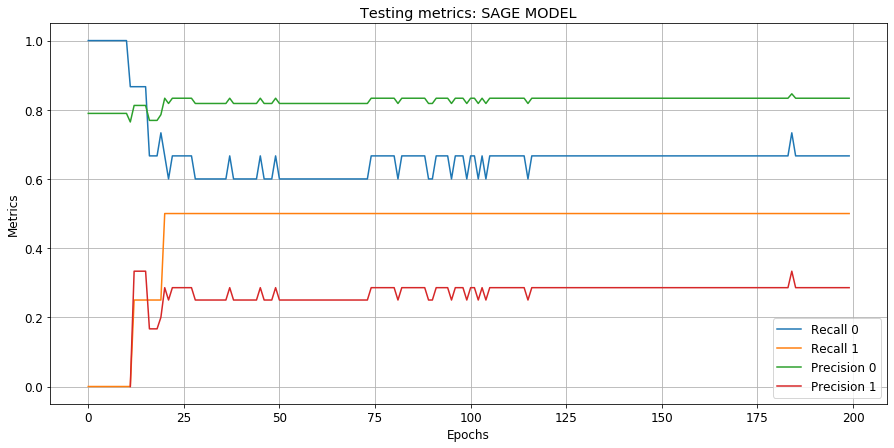

In [142]:
plt.figure(figsize=(15,7))
n = len(recall_class_0)
x_axis = range(n)
plt.plot(x_axis,recall_class_0, label = 'Recall 0'  )
plt.plot(x_axis,recall_class_1, label = 'Recall 1'  )
plt.plot(x_axis,precision_class_0, label = 'Precision 0'  )
plt.plot(x_axis,precision_class_1, label = 'Precision 1'  )
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Testing metrics: SAGE MODEL')
plt.legend()
plt.grid()
plt.savefig(PLOT_DIRECTORY + 'Test_recall_precision: model SAGE: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

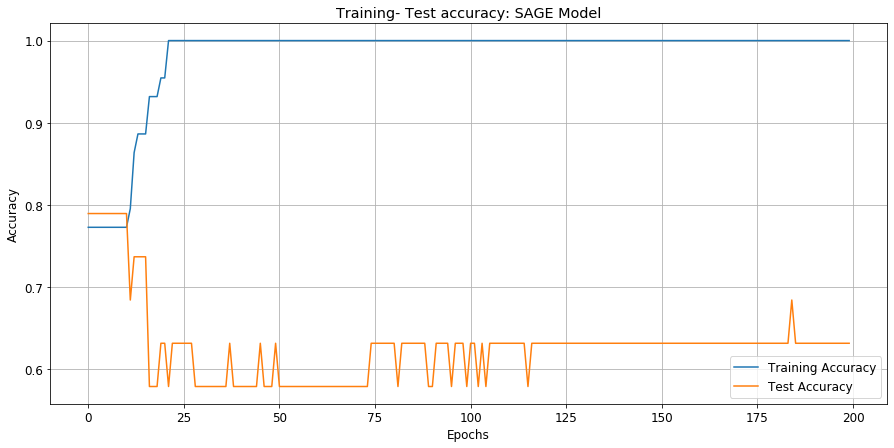

In [143]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch)
plt.plot(range(n),Train_accuracy[:],label= 'Training Accuracy'   )
plt.plot(range(n),Test_accuracy[:], label= 'Test Accuracy' )
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title( 'Training- Test accuracy: SAGE Model' )
plt.savefig(PLOT_DIRECTORY + 'Train -Test Accuracy: model SAGE: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png')
#plt.savefig(PLOT_DIRECTORY + 'Train-Test Accuracy: model GCN Best.png')

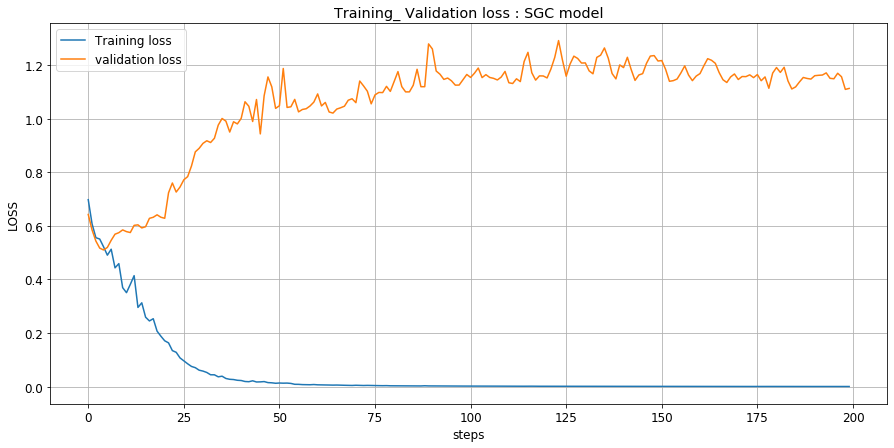

In [144]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch)
plt.plot(range(n),LOSS_epoch[:],label= 'Training loss'   )
plt.plot(range(n),TEST_epoch[:], label= 'validation loss' )



plt.xlabel('steps')
plt.ylabel('LOSS')
plt.grid()
plt.legend()
plt.title( 'Training_ Validation loss : SGC model' )
plt.savefig(PLOT_DIRECTORY + 'Training_vs_Validation_loss: model SAGE: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

In [145]:
N_FOLDS = 9
Learning_rate = 0.01
IN_CHANNELS = 64
HIDDEN_CHANNELS = BATCH_SIZE
N_CLASSES = 2
DROPOUT = 0
CLASS_1_WEIGHT = 2
BATCH_SIZE = 10


index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)




WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)


TRAIN_ACC_BOXPLOT = []
TEST_ACC_BOXPLOT = []
RECALL_1_BOXPLOT = []
RECALL_0_BOXPLOT = []
PRECISION_1_BOXPLOT = []
PRECISION_0_BOXPLOT = []
CONVERGED_TRAINING_LOSS = []
CONVERGED_VALID_LOSS = []


for step in range(N_FOLDS):
    
    print('Fold : ',step)
 
    model = SAGE(hidden_channels=BATCH_SIZE).double()

    criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)
    opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)
    opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)
    optimizer = opt_1
    
    train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
    train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

    train_indicies = train_indicies_class_1 + train_indicies_class_0
    test_indicies = test_indicies_class_1 + test_indicies_class_0 

    train_dataset = [patients_dataset[i] for i in train_indicies] 
    test_dataset = [patients_dataset[i] for i in test_indicies]

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True) 
    
  
    
    LOSS_epoch = []
    TOTAL_LOSS = []
    TEST_epoch = []
    recall_class_0 =[]
    precision_class_0 =[]
    recall_class_1 =[]
    precision_class_1 =[]

    Train_accuracy = []
    Test_accuracy = []


    for epoch in range(1, 201):
        loss = train()
        test_loss = valid()
        #print(loss)
        TOTAL_LOSS = TOTAL_LOSS + loss
        LOSS_epoch.append(np.mean(loss))
        TEST_epoch.append(np.mean(test_loss))
        train_acc = test(train_loader)[0]
        #print('test')
        test_acc = test(test_loader)[0]
        recall_1 = test(test_loader)[2]
        precision_1 = test(test_loader)[1]
        precision_0 = test(test_loader)[3]
        recall_0 = test(test_loader)[4]
    
        recall_class_0.append(recall_0)
        recall_class_1.append(recall_1)
    
        precision_class_0.append(precision_0)
        precision_class_1.append(precision_1)
   
        Train_accuracy.append(train_acc)
        Test_accuracy.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
        
    TRAIN_ACC_BOXPLOT.append(train_acc)
    TEST_ACC_BOXPLOT.append(test_acc)
    RECALL_1_BOXPLOT.append(recall_1)
    RECALL_0_BOXPLOT.append(recall_0)
    PRECISION_1_BOXPLOT.append(precision_1)
    PRECISION_0_BOXPLOT.append(precision_0)
    CONVERGED_TRAINING_LOSS.append(np.mean(loss))
    CONVERGED_VALID_LOSS.append(np.mean(test_loss)) 

Fold :  0


invalid value encountered in long_scalars


Epoch: 200, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
Fold :  1
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2000, recall_1: 0.2500,precision_0: 0.7857,recall_0: 0.7333
Fold :  2
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7333,recall_0: 0.7333
Fold :  3
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2000, recall_1: 0.2500,precision_0: 0.7857,recall_0: 0.7333
Fold :  4


invalid value encountered in long_scalars


Epoch: 200, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7333,recall_0: 0.7333
Fold :  5
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
Fold :  6
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.1429, recall_1: 0.2500,precision_0: 0.7500,recall_0: 0.6000
Fold :  7
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
Fold :  8
Epoch: 200, Train Acc: 0.9773, Test Acc: 0.7368, precision_1: 0.4000, recall_1: 0.5000,precision_0: 0.8571,recall_0: 0.8000


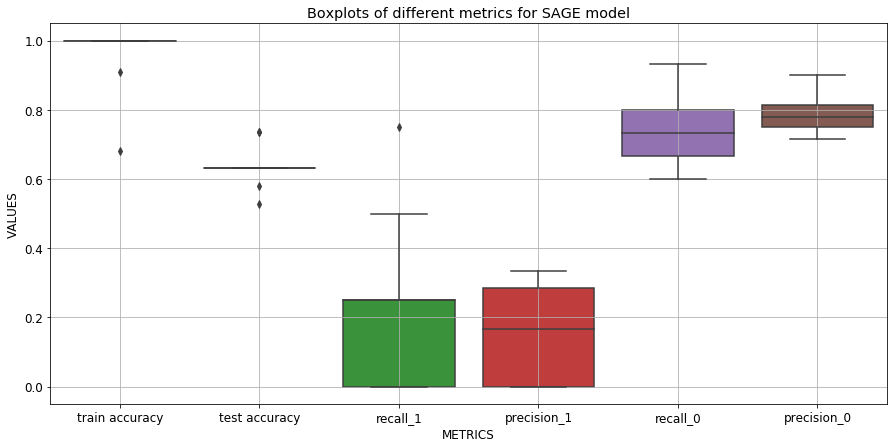

In [146]:
losses_SAGE = pd.DataFrame({},columns =['training_loss', 'validation_loss'])
losses_SAGE['training_loss'] = CONVERGED_TRAINING_LOSS
losses_SAGE['validation_loss'] = CONVERGED_VALID_LOSS


metrics_SAGE = pd.DataFrame({},columns =['train accuracy', 'test accuracy', 'recall_1', 'precision_1', 'recall_0','precision_0'])
metrics_SAGE['train accuracy'] = TRAIN_ACC_BOXPLOT
metrics_SAGE['test accuracy'] = TEST_ACC_BOXPLOT
metrics_SAGE['recall_1'] = RECALL_1_BOXPLOT
metrics_SAGE['recall_0'] = RECALL_0_BOXPLOT
metrics_SAGE['precision_1'] = PRECISION_1_BOXPLOT
metrics_SAGE['precision_0'] = PRECISION_0_BOXPLOT

plt.figure(figsize=(15,7))
sns.boxplot(data=metrics_SGC)
plt.xlabel('METRICS')
plt.ylabel('VALUES')
plt.grid()
plt.title( 'Boxplots of different metrics for SAGE model' )
plt.savefig(PLOT_DIRECTORY + 'BOXPLOTS METRICS SAGE: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 